In [5]:
"""Import library""" 
import numpy as np
import cv2
import os
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, Activation, MaxPool2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import seaborn as sn
import matplotlib.pyplot as plt
import pandas as pd
import imutils
from imutils.contours import sort_contours

In [4]:
x = []
y = []


datadir = 'data/data/dataset'


for folder in os.listdir(datadir):
    path = os.path.join(datadir, folder)
    for images in os.listdir(path):
        img = cv2.imread(os.path.join(path, images))
        x.append(img)
        y.append(folder)
        
print(len(x))
print(len(y))
print(f'Labels : {list(set(y))}')

7600
7600
Labels : ['3', '1', '7', 'mul', '6', 'add', '2', '4', '5', '8', '9', 'sub', '0', 'div']


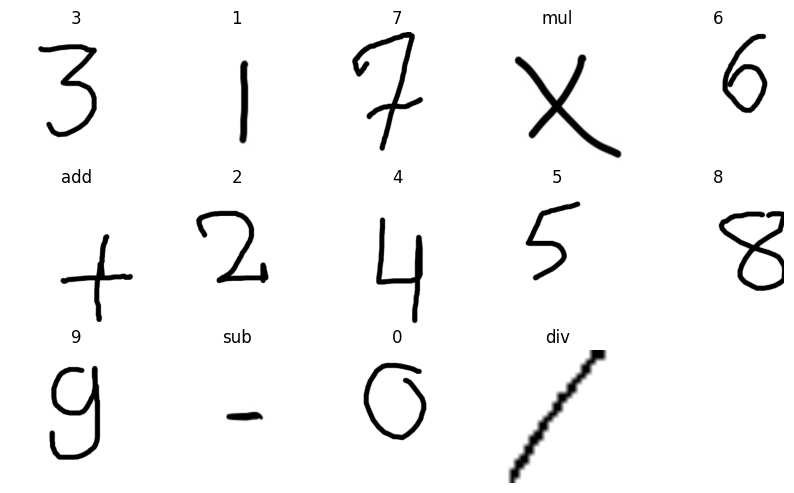

In [5]:
figure = plt.figure(figsize=(10, 10))
j = 0
for i in list(set(y)):
    idx = y.index(i)
    img = x[idx]
    img = cv2.resize(img, (256, 256))
    figure.add_subplot(5, 5, j+1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(i)
    j += 1

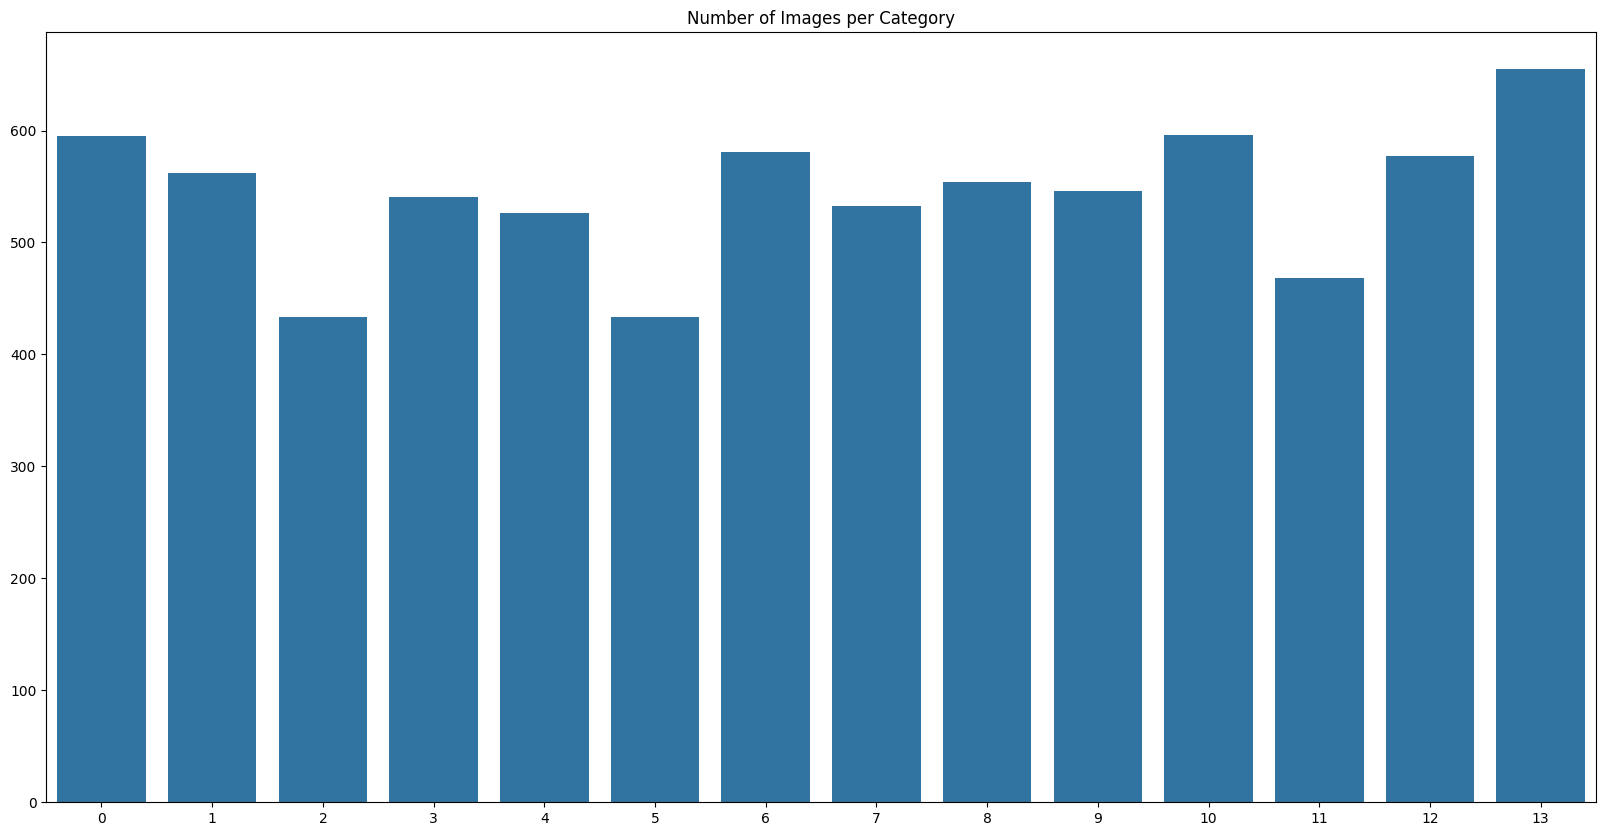

In [6]:
unique, count = np.unique(y, return_counts=True)
figure = plt.figure(figsize=(20, 10))
sn.barplot(count).set_title('Number of Images per Category')
plt.show()

# Preprocessing

In [7]:
X = []
for i in range(len(x)):
#     print(i)
    img = x[i]
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    threshold_image = cv2.threshold(img_gray, 0, 255, cv2.THRESH_BINARY_INV|cv2.THRESH_OTSU)[1]
    threshold_image = cv2.resize(threshold_image, (32, 32))
    X.append(threshold_image)
print(len(X))

7600


In [8]:
# Encoding 
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)
print(len(y))

7600


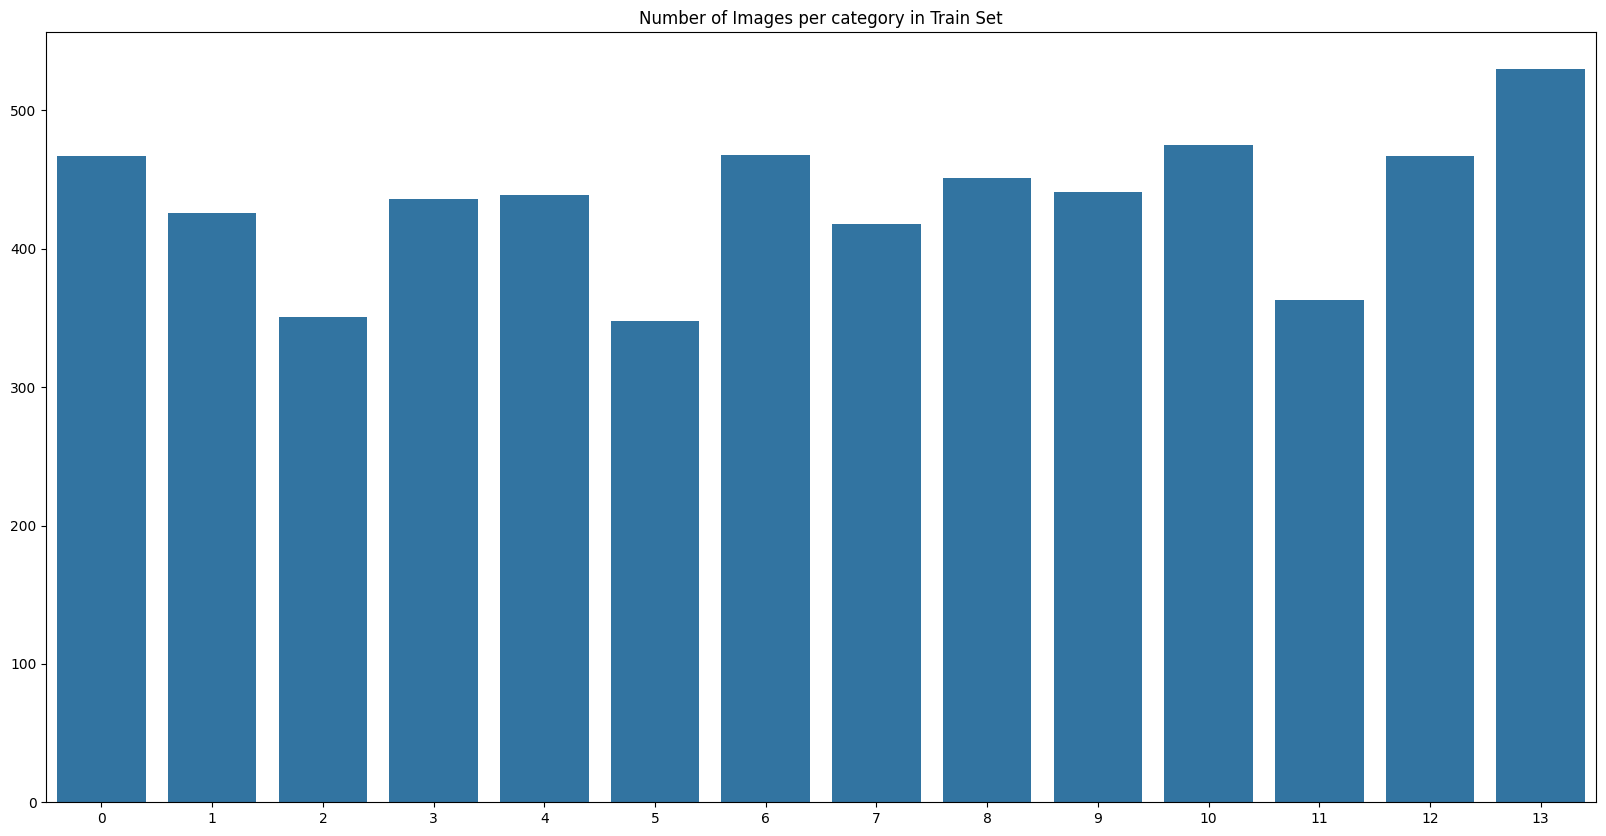

In [9]:
# Train test split
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2)

# Number of images per category in train set
unique_train, count_train = np.unique(Y_train, return_counts=True)
figure = plt.figure(figsize=(20, 10))
sn.barplot(count_train).set_title('Number of Images per category in Train Set')
plt.show()

In [10]:
# Scaling data
X_train = np.array(X_train)
X_test = np.array(X_test)
Y_train = np.array(Y_train)
Y_test = np.array(Y_test)

Y_train = to_categorical(Y_train)
Y_test = to_categorical(Y_test)
X_train = np.expand_dims(X_train, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)
X_train = X_train/255.
X_test = X_test/255.

print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(6080, 32, 32, 1)
(1520, 32, 32, 1)
(6080, 14)
(1520, 14)


## CNN Model

In [11]:
def math_symbol_and_digits_recognition(input_shape=(32, 32, 1)):
    regularizer = l2(0.01)
    model = Sequential()
    model.add(Input(shape=input_shape))
    model.add(Conv2D(32, (3, 3), strides=(1, 1), padding='same', 
                     kernel_initializer=glorot_uniform(seed=0), 
                     name='conv1', activity_regularizer=regularizer))
    model.add(Activation(activation='relu', name='act1'))
    model.add(MaxPool2D((2, 2), strides=(2, 2)))
    model.add(Conv2D(32, (3, 3), strides=(1, 1), padding='same', 
                     kernel_initializer=glorot_uniform(seed=0), 
                     name='conv2', activity_regularizer=regularizer))
    model.add(Activation(activation='relu', name='act2'))
    model.add(MaxPool2D((2, 2), strides=(2, 2)))
    model.add(Conv2D(64, (3, 3), strides=(1, 1), padding='same', 
                     kernel_initializer=glorot_uniform(seed=0), 
                     name='conv3', activity_regularizer=regularizer))
    model.add(Activation(activation='relu', name='act3'))
    model.add(MaxPool2D((2, 2), strides=(2, 2)))
    model.add(Flatten())
    model.add(Dropout(0.5))
    model.add(Dense(120, activation='relu', kernel_initializer=glorot_uniform(seed=0), name='fc1'))
    model.add(Dense(84, activation='relu', kernel_initializer=glorot_uniform(seed=0), name='fc2'))
    model.add(Dense(14, activation='softmax', kernel_initializer=glorot_uniform(seed=0), name='fc3'))
    
    optimizer = Adam()
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

In [12]:
model = math_symbol_and_digits_recognition(input_shape=(32, 32, 1))
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1 (Conv2D)                  │ (None, 32, 32, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ act1 (Activation)               │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2 (Conv2D)                  │ (None, 16, 16, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ act2 (Activation)               │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3 (Conv2D)                  │ (None, 8, 8, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ act3 (Activation)               │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 120)            │       123,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 84)             │        10,164 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc3 (Dense)                     │ (None, 14)             │         1,190 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 162,418 (634.45 KB)

 Trainable params: 162,418 (634.45 KB)

 Non-trainable params: 0 (0.00 B)

In [13]:
def step_decay(epoch):
    initial_learning_rate = 0.001
    dropEvery = 10
    factor = 0.5
    lr = initial_learning_rate*(factor**np.floor((1 + epoch)/dropEvery))
    return float(lr)

checkpoint = ModelCheckpoint('maths_symbol_and_digits_recognition.keras', 
                             monitor='val_loss', save_best_only=True, 
                             verbose=1, mode='min')

callbacks = [checkpoint, LearningRateScheduler(step_decay)]

In [14]:
aug = ImageDataGenerator(
    zoom_range=0.1,
    rotation_range=5,
    width_shift_range=0.05,
    height_shift_range=0.05,
    shear_range=0.2
)


In [15]:
hist = model.fit(aug.flow(X_train, Y_train, batch_size=128), batch_size=128, epochs=500, validation_data=(X_test, Y_test))

c:\Users\imalightbulb\XMDriveV2\personal_space\Y1S1\Code\math-recog\math-recog\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/500
48/48 ━━━━━━━━━━━━━━━━━━━━ 13s 131ms/step - accuracy: 0.1411 - loss: 69.0702 - val_accuracy: 0.1579 - val_loss: 36.6022
Epoch 2/500
48/48 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/step - accuracy: 0.2442 - loss: 17.3148 - val_accuracy: 0.2507 - val_loss: 17.5328
Epoch 3/500
48/48 ━━━━━━━━━━━━━━━━━━━━ 6s 115ms/step - accuracy: 0.3018 - loss: 8.1339 - val_accuracy: 0.1474 - val_loss: 10.8943
Epoch 4/500
48/48 ━━━━━━━━━━━━━━━━━━━━ 5s 108ms/step - accuracy: 0.4074 - loss: 4.8370 - val_accuracy: 0.3000 - val_loss: 7.1915
Epoch 5/500
48/48 ━━━━━━━━━━━━━━━━━━━━ 5s 105ms/step - accuracy: 0.4753 - loss: 3.3914 - val_accuracy: 0.3428 - val_loss: 5.5199
Epoch 6/500
48/48 ━━━━━━━━━━━━━━━━━━━━ 5s 101ms/step - accuracy: 0.4886 - loss: 2.7030 - val_accuracy: 0.4072 - val_loss: 4.3549
Epoch 7/500
48/48 ━━━━━━━━━━━━━━━━━━━━ 5s 103ms/step - accuracy: 0.5061 - loss: 2.3034 - val_accuracy: 0.3908 - val_loss: 3.8153
Epoch 8/500
48/48 ━━━━━━━━━━━━━━━━━━━━ 5s 104ms/step - accuracy: 0.5266 - loss: 2.1069 - va

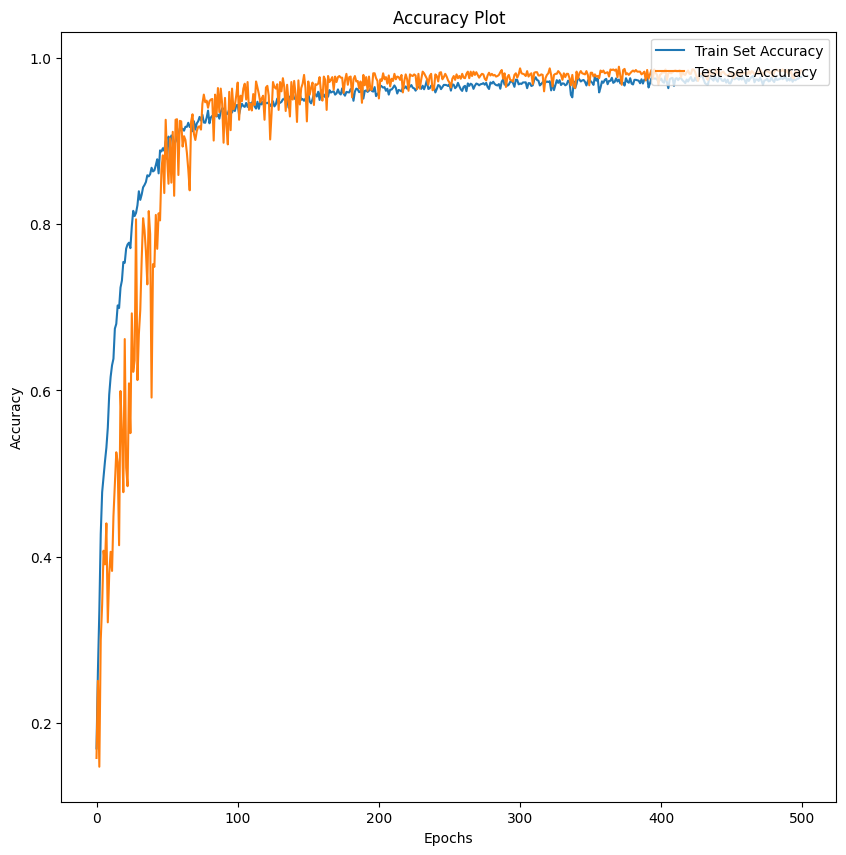

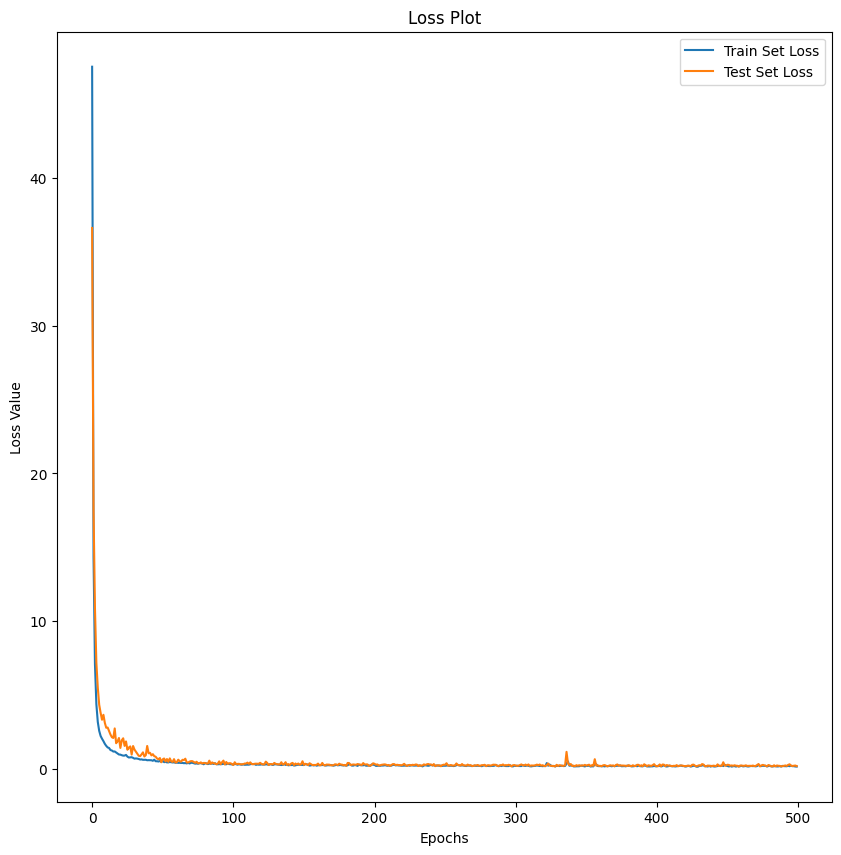

In [16]:
figure = plt.figure(figsize=(10, 10))
plt.plot(hist.history['accuracy'], label='Train Set Accuracy')
plt.plot(hist.history['val_accuracy'], label='Test Set Accuracy')
plt.title('Accuracy Plot')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='upper right')
plt.show()

figure2 = plt.figure(figsize=(10, 10))
plt.plot(hist.history['loss'], label='Train Set Loss')
plt.plot(hist.history['val_loss'], label='Test Set Loss')
plt.title('Loss Plot')
plt.xlabel('Epochs')
plt.ylabel('Loss Value')
plt.legend(loc='upper right')
plt.show()

In [17]:
ypred = model.predict(X_test)
ypred = np.argmax(ypred, axis=1)
Y_test_hat = np.argmax(Y_test, axis=1)
print(classification_report(Y_test_hat, ypred))

48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
              precision    recall  f1-score   support

           0       0.99      0.98      0.99       128
           1       1.00      0.96      0.98       136
           2       0.99      1.00      0.99        82
           3       0.97      0.99      0.98       105
           4       0.99      0.95      0.97        87
           5       0.99      0.98      0.98        85
           6       0.98      0.98      0.98       113
           7       0.96      0.98      0.97       115
           8       0.98      0.99      0.99       103
           9       0.97      0.99      0.98       105
          10       0.97      1.00      0.98       121
          11       1.00      1.00      1.00       105
          12       1.00      0.98      0.99       110
          13       1.00      1.00      1.00       125

    accuracy                           0.98      1520
   macro avg       0.98      0.98      0.98      1520
weighted avg       0.99      0.98      0.

In [18]:
model.save('maths_symbol_and_digits_recognition.keras')


## Confusion Matrix and Classification

190/190 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       467
           1       1.00      0.97      0.99       426
           2       1.00      1.00      1.00       351
           3       1.00      1.00      1.00       436
           4       0.99      1.00      1.00       439
           5       1.00      1.00      1.00       348
           6       0.99      1.00      0.99       468
           7       0.97      1.00      0.98       418
           8       1.00      1.00      1.00       451
           9       1.00      0.99      0.99       441
         add       0.99      1.00      1.00       475
         div       1.00      1.00      1.00       363
         mul       1.00      0.99      1.00       467
         sub       1.00      1.00      1.00       530

    accuracy                           1.00      6080
   macro avg       1.00      1.00      1.00      6080
weighted avg     

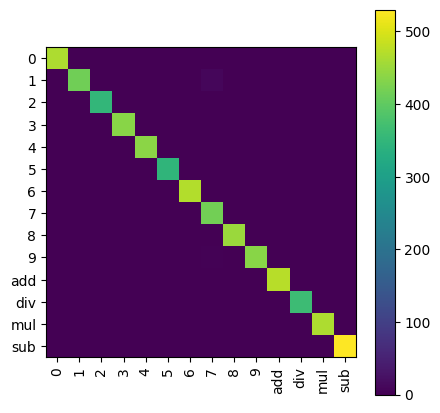

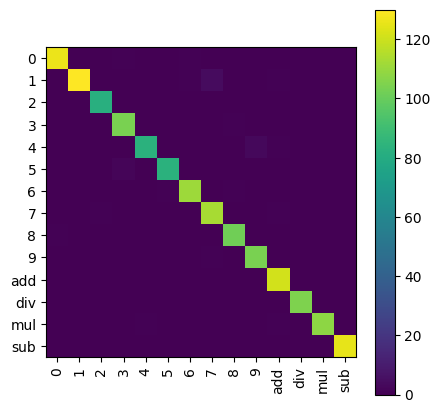

In [19]:
def confusion_mat(X, y):
    y_pred = model.predict(X)
    y_pred = np.argmax(y_pred, axis=1)
    y_target = np.argmax(y, axis=1)
    target_names = label_encoder.classes_
    
    print('Classification Report')
    target_names = label_encoder.classes_
    print(classification_report(y_target, y_pred, target_names=target_names))
    
    print('Confusion Matrix')
    cm_train = confusion_matrix(y_target , y_pred)
    print(cm_train)
    
    plt.figure(figsize=(5,5))
    plt.imshow(cm_train, interpolation='nearest')
    plt.colorbar()
    tick_mark = np.arange(len(target_names))
    _ = plt.xticks(tick_mark, target_names, rotation=90)
    _ = plt.yticks(tick_mark, target_names)
    
# Train Set
confusion_mat(X_train,Y_train)

# Test Set
confusion_mat(X_test,Y_test)

# Testing the Model

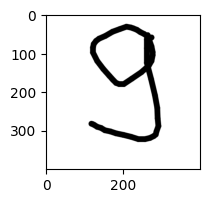

In [20]:
# Get test image
image = cv2.imread(r'C:\Users\imalightbulb\XMDriveV2\personal_space\Y1S1\Code\math-recog\data\data\dataset\9\WaUUKSMM.png',cv2.IMREAD_GRAYSCALE)
plt.figure(figsize=(2, 2))
plt.imshow(image,cmap='gray')
plt.show()

In [2]:
def image_preprocessing(image):
    image = cv2.resize(image, (32, 32))
    arrim = np.array(image)
    arrim = np.expand_dims(arrim, axis=-1)
    arrim = arrim/255.
    arrim = np.array([np.array(arrim)])
    return arrim

In [3]:
# Make a prediction
prediction = model.predict(image_preprocessing(image))
prediction

NameError: name 'model' is not defined

In [23]:
label_encoder.classes_[np.argmax(prediction)]


np.str_('8')

In [6]:
import imutils 
model = tf.keras.models.load_model('maths_symbol_and_digits_recognition.keras')

def eqn_recog(image_path):
    chars = []
    img = cv2.imread(image_path)
    img = cv2.resize(img, (800, 800))
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    edged = cv2.Canny(img_gray, 30, 150)
    contours = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = imutils.grab_contours(contours)
    contours = imutils.contours.sort_contours(contours, method="left-to-right")[0]
    labels = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'add', 'div', 'mul', 'sub']
    
    for c in contours:
        (x, y, w, h) = cv2.boundingRect(c)
        if 20<=w and 30<=h:
            roi = img_gray[y:y+h, x:x+w]
            thresh = cv2.threshold(roi, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
            (th, tw) = thresh.shape
            if tw > th:
                thresh = imutils.resize(thresh, width=32)
            if th > tw:
                thresh = imutils.resize(thresh, height=32)
            (th, tw) = thresh.shape
            dx = int(max(0, 32 - tw)/2.0)
            dy = int(max(0, 32 - th) / 2.0)
            padded = cv2.copyMakeBorder(thresh, top=dy, bottom=dy, left=dx, right=dx, borderType=cv2.BORDER_CONSTANT,
                                       value=(0, 0, 0))
            padded = cv2.resize(padded, (32, 32))
            padded = np.array(padded)
            padded = padded/255.
            padded = np.expand_dims(padded, axis=0)
            padded = np.expand_dims(padded, axis=-1)
            pred = model.predict(padded)
            pred = np.argmax(pred, axis=1)
            label = labels[pred[0]]
            chars.append(label)
            cv2.rectangle(img, (x, y), (x+w, y+h), (0, 0, 255), 2)
            cv2.putText(img, label, (x-5, y), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255))

    figure = plt.figure(figsize=(10, 10))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.axis('off')
    plt.show()
    e = ''
    for i in chars:
        if i=='add':
            e += '+'
        elif i=='sub':
            e += '-'
        elif i=='mul':
            e += '*'
        elif i=='div':
            e += '/'
        else:
            e += i
    v = eval(e)
    print('Value of the expression {} : {}'.format(e, v)) 
    

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


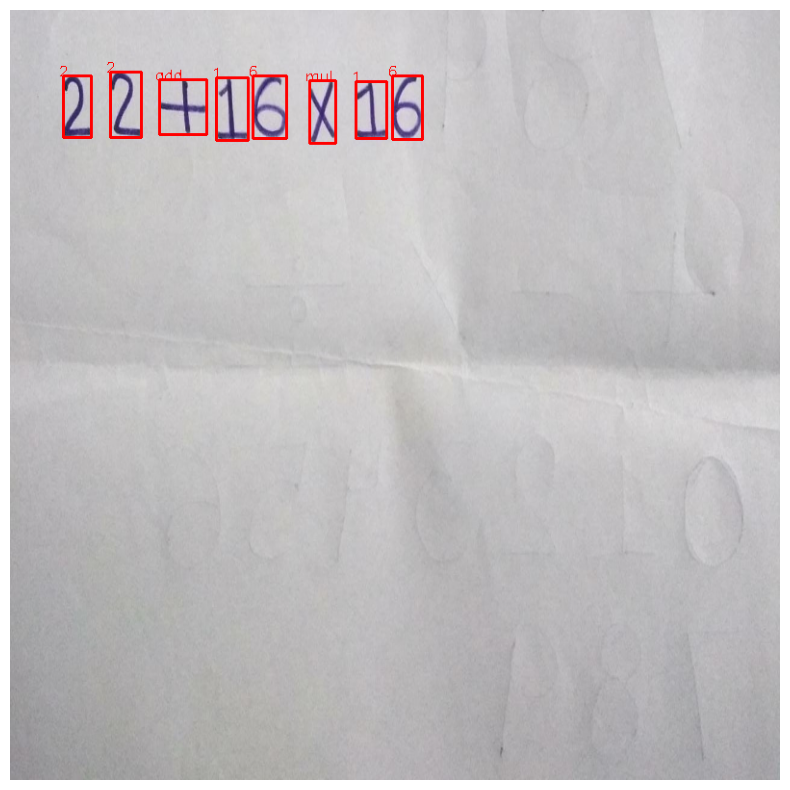

Value of the expression 22+16*16 : 278


In [11]:


eqn_recog(r'data/data/test_equation4.jpg')